In [1]:
using Revise

In [2]:
Revise.revise()

In [1]:
using LinearAlgebra
using Random, Distributions
using MLJ
using DataFrames
using MLJLinearModels
using Plots

In [4]:
using Suppressor

In [2]:
include("qsrfe/src/qsrfe.jl")
using .qsrfe

In [ ]:
# DATASETS
# 2-order function:
d = 10 # dimension of feature vectors
m = 50 #number of features in dataset
γ = 1 #x spread
X = rand(Normal(0.0,γ),(m,d))
f = function(x) 
    s = 0
    for i in 1:(length(x)-1)
        s += exp(-x[i]^2) / (x[i+1]^2 + 1)
    end
    return 1/length(x) .* s
end
Y = [f(X[i,:]) for i in 1:m]

Xtest = rand(Normal(0.0,γ),(m,d))
Ytest = [f(Xtest[i,:]) for i in 1:m]

0.21492132274396117

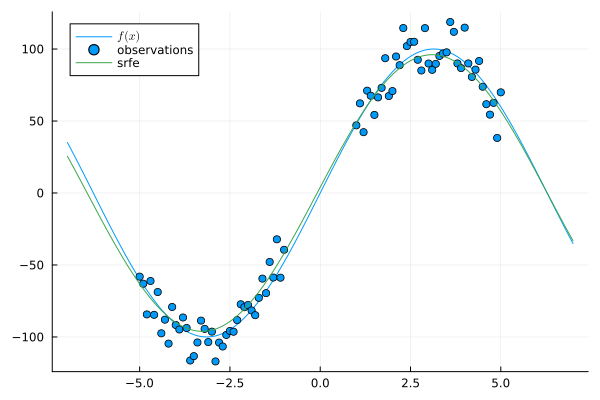

In [26]:
#one dim toy
f_truth(x) = 100*sin(x/2)

x_train = vcat(collect(-5:0.1:-1),collect(1:0.1:5))[:,:]
x_test = vec(-7:0.1:7)[:,:]

noise = rand(Normal(0.0,10), length(x_train))
y_train = vec(f_truth.(x_train) + noise)
y_test = vec(f_truth.(x_test))




λ = 3
N=10000
func=rff
c, ω, ζ = fit_srfe(x_train,y_train,λ,N,func;σ2=1,q=0, quantization=0,K=1,r=1,max_iter=30000)
y_pred = compute_featuremap(x_test,ω,func,ζ) * c
print(rel_error(y_pred,y_test))
plot(x_test, y_test; label=raw"$f(x)$")
scatter!(x_train, y_train; seriescolor=1, label="observations")
plot!(x_test, y_pred; label="srfe")


#plot(c)
##########


In [3]:
#boston dataset
bX, bY = @load_boston
bX = Matrix(DataFrame(bX))
bY = collect(bY)
bX

bX = (bX .- mean(bX)) ./ std(bX)
#bY = (bY .- mean(bY)) ./ std(bY)
(Xtrain, Xtest), (ytrain, ytest) = partition((bX, bY), 0.8, rng=123, multi=true)

(([-0.5038479125622459 -0.3736555203370192 … 2.078229709420622 -0.467825129690138; -0.501959374129676 -0.5073242348197996 … 1.4241218550991361 -0.42919487120461447; … ; -0.5071204568645706 -0.13973526999215344 … 2.0856483230744165 -0.4765135961315187; -0.45784081189620396 -0.5073242348197996 … 1.595551981423302 -0.3308815317025295], [-0.507019470150779 -0.5073242348197996 … 2.117929317622008 -0.4170310181866815; -0.438932637054685 -0.5073242348197996 … 2.0303763096357867 -0.38682188871357304; … ; -0.20158311583976354 -0.5073242348197996 … 0.08262263654995178 -0.2601707817411386; -0.5037144443508349 -0.3736555203370192 … 2.117929317622008 -0.4432300862253064]), ([48.8, 20.2, 20.9, 13.4, 12.7, 13.6, 22.1, 24.4, 13.3, 20.3  …  36.2, 20.7, 42.3, 5.0, 18.7, 19.6, 17.9, 41.7, 31.2, 17.2], [23.3, 14.6, 32.0, 22.6, 14.1, 19.1, 20.3, 12.6, 50.0, 24.8  …  22.2, 19.8, 31.7, 27.1, 19.5, 24.6, 15.6, 26.4, 7.0, 33.8]))

Relative Error: 0.09921877782373777, Training Error: 0.09614175351395737
Absolute Error: 2.101021869484959, Abs Training Error: 1.8227827895398647

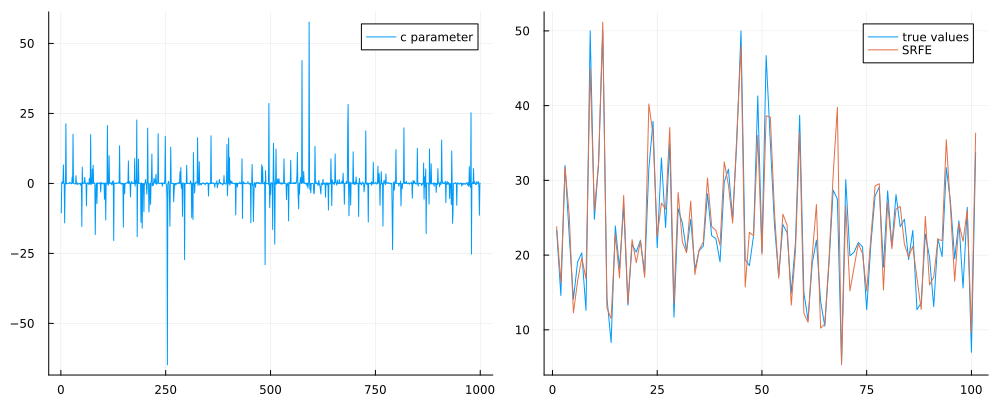

In [4]:
##########################################################
N = 1000
λ = 0.0006
func = rff

#fitting

c, ω, ζ = fit_srfe(Xtrain,ytrain,λ,N,func;σ2=1,q=0, quantization=0,K=2,r=1,β=1.1,clambda=0, limit=1,pruning=1.0,max_iter=20000)
y_pred = compute_featuremap(Xtest,ω,func,ζ) * c
y_trainpred = compute_featuremap(Xtrain,ω,func,ζ) * c
println("Relative Error: $(rel_error(ytest,y_pred)), Training Error: $(rel_error(ytrain,y_trainpred))")
println("Absolute Error: $(mean(abs.(ytest-y_pred))), Abs Training Error: $(mean(abs.(ytrain-y_trainpred)))")
p1 = plot(c,label="c parameter")
p2 = plot(ytest, label="true values")
plot!(y_pred, label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))

Relative Error: 0.09283038017195229, Training Error: 0.05104157171409832
Absolute Error: 1.891879046507914, Abs Training Error: 0.9836722629486738


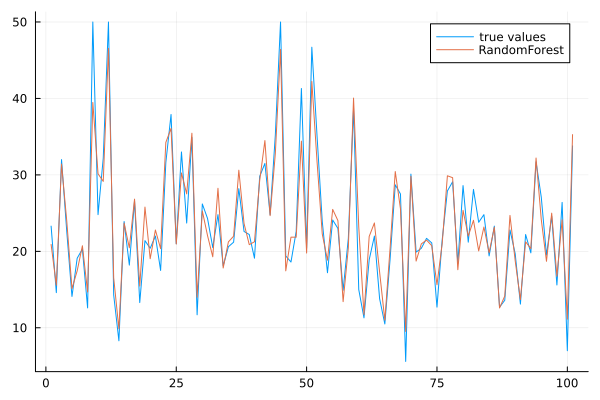

In [32]:
#RandomForest Regression
modelType = @load RandomForestRegressor pkg = "BetaML" verbosity=0 
model= modelType()
(fitResults, cache, report) = MLJ.fit(model, 0, Xtrain, ytrain)
y_pred = predict(model, fitResults, Xtest)
y_trainpred = predict(model, fitResults, Xtrain)
println("Relative Error: $(rel_error(ytest,y_pred)), Training Error: $(rel_error(ytrain,y_trainpred))")
println("Absolute Error: $(mean(abs.(ytest-y_pred))), Abs Training Error: $(mean(abs.(ytrain-y_trainpred)))")
plot(ytest, label="true values")
plot!(y_pred, label="RandomForest")

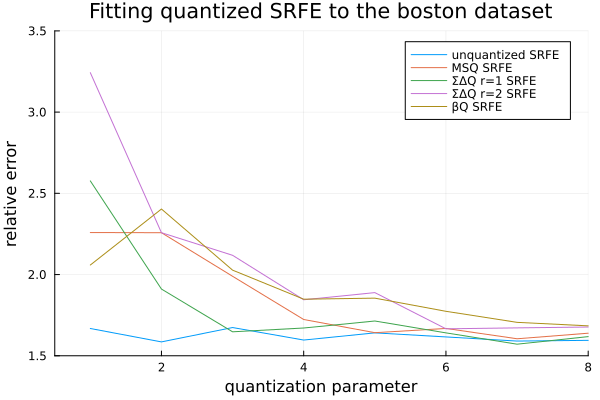

In [20]:
plot()
xlims!(0.5, 8)
ylims!(1.5,3.5)
title!("Fitting quantized SRFE to the boston dataset")
xlabel!("quantization parameter")
ylabel!("relative error")
Kmax=8
trials = 1
r=1

@suppress_err begin
    quantization = 0
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="unquantized SRFE")

    quantization = 1
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="MSQ SRFE")

    quantization = 2
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="ΣΔQ r=1 SRFE")

    r=2
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="ΣΔQ r=2 SRFE")

    quantization = 3
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="βQ SRFE")
end






In [ ]:
#plots
plot(c)

plot(c)
prune!(c,0.01)
plot(abs.(y_pred - ytest))

plot(ytest)
plot!(y_pred)

Relative Error: 0.5154296436262226, Training Error: 0.18452768871751882
Absolute Error: 10.114041377991128, Abs Training Error: 3.7917084180807543


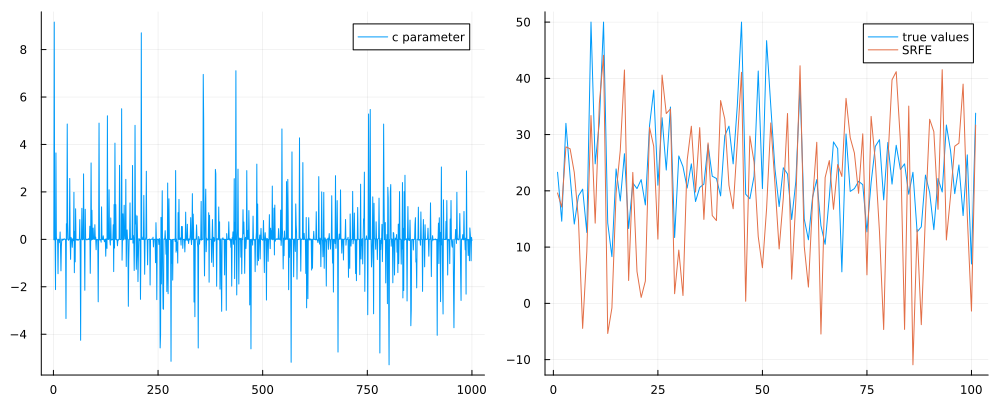

In [11]:
N = 1000
λ = 0.0006
func = rff

#fitting
clambda = 1
r=1
β = 1.2
K=3

c, ω, ζ = fit_srfe(Xtrain,ytrain,λ,N,func;σ2=1,q=0, quantization=2,K=K,r=r,β=β,clambda=clambda,condensation=false, limit=1,pruning=1.0,max_iter=20000)
A=compute_featuremap(Xtest,ω,func,ζ)
A= ΣΔQ(A,3,2)
#A = ΣΔcondense(A,r,clambda)
#A = βcondense(A,β,clambda)
y_pred = A * c
At = compute_featuremap(Xtrain,ω,func,ζ)

#At = ΣΔcondense(At,r,clambda)
#At = βcondense(At,β,clambda)
y_trainpred = At * c
println("Relative Error: $(rel_error(ytest,y_pred)), Training Error: $(rel_error(ytrain,y_trainpred))")
println("Absolute Error: $(mean(abs.(ytest-y_pred))), Abs Training Error: $(mean(abs.(ytrain-y_trainpred)))")
p1 = plot(c,label="c parameter")
p2 = plot(ytest, label="true values")
plot!(y_pred, label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))